# Notebook 03: Modeling and Model Selection

In [1]:
# for data manipulation
import pandas as pd
import numpy as np
import pickle

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# for data evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, \
                            recall_score, f1_score, plot_roc_curve, roc_auc_score, average_precision_score, \
                            precision_recall_curve, ConfusionMatrixDisplay, plot_precision_recall_curve

# Use a classifier from PyCaret
from pycaret.classification import *
from imblearn.combine import SMOTETomek
smtom = SMOTETomek(sampling_strategy='minority')

%matplotlib inline

C:\Users\chua_\anaconda3\envs\dsi-sg\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# create a function to run the metrics and store it in dataframe
evaluation_list = []

def run_score(fit_model, model, scale=False):
    
    summary_dict = {}

    if scale:
        y_pred = fit_model.predict(X_test_sc)
        train = fit_model.score(X_train_sc, y_train)
        test = fit_model.score(X_test_sc, y_test)
        roc_auc = roc_auc_score(y_test, fit_model.predict_proba(X_test_sc)[:,1])

        # store the results in summary dictionary
        summary_dict['model'] = model
        summary_dict['train accuracy'] = train
        summary_dict['test accuracy'] = test
        summary_dict['precision'] = precision_score(y_test, y_pred)
        summary_dict['recall'] = recall_score(y_test, y_pred)
        summary_dict['average precision'] = average_precision_score(y_test, y_pred)
        summary_dict['f1_score'] = f1_score(y_test, y_pred)
        summary_dict['roc_auc'] = roc_auc

        evaluation_list.append(summary_dict)

        # print summarize results
        print(f"====== {model}'s Metrics ======")
        print(f"Train Score: {train}")
        print(f"Test Score: {test}")    
        print(f"Precision Score: {precision_score(y_test, y_pred)}")
        print(f"Recall Score: {recall_score(y_test, y_pred)}")
        print(f"Average Precision: {average_precision_score(y_test, y_pred)}")
        print(f"f1-Score: {f1_score(y_test, y_pred)}")
        print(f"roc_auc Score: {roc_auc}")

        print()
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        print('== confusion matrix ==')
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")
    
    else:      
        y_pred = fit_model.predict(X_test)
        train = fit_model.score(X_train, y_train)
        test = fit_model.score(X_test, y_test)
        roc_auc = roc_auc_score(y_test, fit_model.predict_proba(X_test)[:,1])

        # store the results in summary dictionary
        summary_dict['model'] = model
        summary_dict['train accuracy'] = train
        summary_dict['test accuracy'] = test
        summary_dict['precision'] = precision_score(y_test, y_pred)
        summary_dict['recall'] = recall_score(y_test, y_pred)
        summary_dict['average precision'] = average_precision_score(y_test, y_pred)
        summary_dict['f1_score'] = f1_score(y_test, y_pred)
        summary_dict['roc_auc'] = roc_auc

        evaluation_list.append(summary_dict)

        # print summarize results
        print(f"====== {model}'s Metrics ======")
        print(f"Train Score: {train}")
        print(f"Test Score: {test}")    
        print(f"Precision Score: {precision_score(y_test, y_pred)}")
        print(f"Recall Score: {recall_score(y_test, y_pred)}")
        print(f"Average Precision: {average_precision_score(y_test, y_pred)}")
        print(f"f1-Score: {f1_score(y_test, y_pred)}")
        print(f"roc_auc Score: {roc_auc}")

        print()
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        print('== confusion matrix ==')
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")

In [137]:
# define a function to check missing columns among two df
def check_col(df1, df2):    
    missing_col_list = []
    for col in df1.columns:
        if col not in df2.columns:
            missing_col_list.append(col) 
    return missing_col_list

Precision measures how accurate your predictions are. i.e. the percentage of your predictions are correct.

Precision = TP / TP+FP

mAP (mean average precision) is the average of AP.

ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance.

### Load Cleaned and Combined Data

In [4]:
# load the pickle file
train_final = pd.read_pickle('../datasets/train_final.pkl')
test_final = pd.read_pickle('../datasets/test_final.pkl')

In [5]:
print(train_final.shape)
train_final.head(3)

(1296675, 79)


,trans_datetime,cc_num,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,trans_num,merch_lat,merch_long,is_fraud,name,coords_ori,coords_merch,trans_year,trans_month,trans_week,trans_day,trans_hour,trans_minute,trans_dayofweek,age,distance,amt_group,age_group,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,diff_minutes_pre_trans,diff_distance,trans_last_5T,trans_last_1h,trans_last_24h,trans_last_7d,trans_last_30d,avg_last_5T,avg_last_1h,avg_last_24h,avg_last_7d,avg_last_30d,min_last_5T,min_last_1h,min_last_24h,min_last_7d,min_last_30d,max_last_5T,max_last_1h,max_last_24h,max_last_7d,max_last_30d,merch_last_24h,merch_last_7d,merch_last_14d,merch_last_30d,avg_merch_last_24h,avg_merch_last_7d,avg_merch_last_14d,avg_merch_last_30d,min_merch_last_24h,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d,internet_transaction,customer_segment,cluster,anomaly_scores
0,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,98e3dcf98101146a577f85a34e58feec,43.974711,-109.741904,0,Mary Diaz,"(43.0048, -108.8964)","(43.974711, -109.741904)",2019,1,1,1,12,47,1,33,127.629296,low,23_33,0.00,7.27,0.00,0.000000,7.270,0.00,0.000000,1.0,1.0,1.0,1.0,1.0,7.27,7.27,7.270,7.270,7.270,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,1.0,1.0,1.0,1.0,7.2700,7.270,7.270,7.270,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,1,Medium_Value_Cust,43,-0.002765
1,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,498120fc45d277f7c88e3dba79c33865,42.018766,-109.044172,0,Mary Diaz,"(43.0048, -108.8964)","(42.018766, -109.044172)",2019,1,1,2,8,44,2,33,110.202992,above_medium,23_33,7.27,60.21,45.67,6.281981,30.105,1197.70,224.614202,1.0,1.0,2.0,2.0,2.0,52.94,52.94,30.105,30.105,30.105,52.94,52.94,7.27,7.27,7.27,52.94,52.94,52.94,52.94,52.94,4.0,7.0,7.0,7.0,67.6175,67.300,67.300,67.300,52.94,52.94,52.94,52.94,79.01,79.39,79.39,79.39,0,Medium_Value_Cust,43,0.018890
2,2019-01-02 08:47:36,60416207185,fraud_Luettgen_PLC,gas_transport,82.08,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,95f514bb993151347c7acdf8505c3d62,42.961335,-109.157564,0,Mary Diaz,"(43.0048, -108.8964)","(42.961335, -109.157564)",2019,1,1,2,8,47,2,33,21.841827,above_medium,23_33,52.94,142.29,29.14,0.550434,47.430,2.65,105.117359,2.0,2.0,3.0,3.0,3.0,67.51,67.51,47.430,47.430,47.430,52.94,52.94,7.27,7.27,7.27,82.08,82.08,82.08,82.08,82.08,2.0,5.0,5.0,5.0,69.7150,66.778,66.778,66.778,57.35,47.10,47.10,47.10,82.08,82.08,82.08,82.08,0,Medium_Value_Cust,43,0.024193


In [6]:
print(test_final.shape)
test_final.head(3)

(555719, 79)


,trans_datetime,cc_num,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,trans_num,merch_lat,merch_long,is_fraud,name,coords_ori,coords_merch,trans_year,trans_month,trans_week,trans_day,trans_hour,trans_minute,trans_dayofweek,age,distance,cluster,amt_group,age_group,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,diff_minutes_pre_trans,diff_distance,trans_last_5T,trans_last_1h,trans_last_24h,trans_last_7d,trans_last_30d,avg_last_5T,avg_last_1h,avg_last_24h,avg_last_7d,avg_last_30d,min_last_5T,min_last_1h,min_last_24h,min_last_7d,min_last_30d,max_last_5T,max_last_1h,max_last_24h,max_last_7d,max_last_30d,merch_last_24h,merch_last_7d,merch_last_14d,merch_last_30d,avg_merch_last_24h,avg_merch_last_7d,avg_merch_last_14d,avg_merch_last_30d,min_merch_last_24h,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d,internet_transaction,anomaly_scores,customer_segment
0,2020-06-21 13:05:42,60416207185,fraud_Kutch-Ferry,home,124.66,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,f21e1a09f59c50a66735409308285b1d,42.945526,-108.530901,0,Mary Diaz,"(43.0048, -108.8964)","(42.945526, -108.530901)",2020,6,25,21,13,5,6,34,30.533617,43,high,33_43,0.00,124.66,0.00,0.000000,124.660000,0.00,0.000000,1.0,1.0,1.0,1.0,1.0,124.66,124.66,124.660000,124.660000,124.660000,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,1.0,1.0,1.0,1.0,124.660000,124.660000,124.660000,124.660000,124.66,124.66,124.66,124.66,124.66,124.66,124.66,124.66,0,-0.080360,Lost_Cust
1,2020-06-21 16:25:36,60416207185,fraud_Halvorson_Group,misc_pos,78.52,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,08f67c9765438973006f8250351d8c1f,42.193130,-108.682054,0,Mary Diaz,"(43.0048, -108.8964)","(42.19313, -108.682054)",2020,6,25,21,16,25,6,34,91.864216,43,above_medium,33_43,124.66,203.18,-46.14,-0.370127,101.590000,199.90,84.495812,1.0,1.0,2.0,2.0,2.0,78.52,78.52,101.590000,101.590000,101.590000,78.52,78.52,78.52,78.52,78.52,78.52,78.52,124.66,124.66,124.66,1.0,1.0,1.0,1.0,78.520000,78.520000,78.520000,78.520000,78.52,78.52,78.52,78.52,78.52,78.52,78.52,78.52,0,-0.055430,Lost_Cust
2,2020-06-22 07:58:33,60416207185,fraud_Conroy-Cruickshank,gas_transport,65.25,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,ca1f04d9d549c507356ffa8f9b43d81f,43.932724,-109.699794,0,Mary Diaz,"(43.0048, -108.8964)","(43.932724, -109.699794)",2020,6,26,22,7,58,0,34,121.877934,43,above_medium,33_43,78.52,268.43,-13.27,-0.169002,89.476667,932.95,210.284759,1.0,1.0,3.0,3.0,3.0,65.25,65.25,89.476667,89.476667,89.476667,65.25,65.25,65.25,65.25,65.25,65.25,65.25,124.66,124.66,124.66,3.0,3.0,3.0,3.0,58.963333,58.963333,58.963333,58.963333,47.58,47.58,47.58,47.58,65.25,65.25,65.25,65.25,0,-0.062051,Lost_Cust


In [7]:
train_final.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amt', 'is_male',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'trans_num', 'merch_lat', 'merch_long', 'is_fraud', 'name',
       'coords_ori', 'coords_merch', 'trans_year', 'trans_month', 'trans_week',
       'trans_day', 'trans_hour', 'trans_minute', 'trans_dayofweek', 'age',
       'distance', 'amt_group', 'age_group', 'pre_amt', 'cum_sum', 'amt_diff',
       'pct_change', 'amt_avg', 'diff_minutes_pre_trans', 'diff_distance',
       'trans_last_5T', 'trans_last_1h', 'trans_last_24h', 'trans_last_7d',
       'trans_last_30d', 'avg_last_5T', 'avg_last_1h', 'avg_last_24h',
       'avg_last_7d', 'avg_last_30d', 'min_last_5T', 'min_last_1h',
       'min_last_24h', 'min_last_7d', 'min_last_30d', 'max_last_5T',
       'max_last_1h', 'max_last_24h', 'max_last_7d', 'max_last_30d',
       'merch_last_24h', 'merch_last_7d', 'merch_last_14d', 'merch_last_30d',
       'avg_merch_last_24h', 'avg_merch_

In [8]:
columns_to_drop = ['trans_datetime', 'cc_num', 'merchant', 'street', 'city', 'zip', 'lat', 'long', 'city_pop', 'job',
                   'trans_num', 'merch_lat', 'merch_long', 'name', 'coords_ori', 'coords_merch', 'trans_year', 'trans_minute','anomaly_scores']

In [9]:
train_final.drop(columns = columns_to_drop, axis=1, inplace=True)
test_final.drop(columns = columns_to_drop, axis=1, inplace=True)

In [10]:
# specified X and Y
X = train_final.drop('is_fraud', axis=1)
y = train_final['is_fraud']

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 59 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   category                1296675 non-null  object  
 1   amt                     1296675 non-null  float64 
 2   is_male                 1296675 non-null  int64   
 3   state                   1296675 non-null  object  
 4   trans_month             1296675 non-null  int64   
 5   trans_week              1296675 non-null  int32   
 6   trans_day               1296675 non-null  int64   
 7   trans_hour              1296675 non-null  int64   
 8   trans_dayofweek         1296675 non-null  int64   
 9   age                     1296675 non-null  int64   
 10  distance                1296675 non-null  float64 
 11  amt_group               1296675 non-null  category
 12  age_group               1296675 non-null  category
 13  pre_amt                 1296675 non-null  

In [12]:
# convert datetime to object type for dummified
for col in ['trans_month','trans_week','trans_day','trans_hour','trans_dayofweek','cluster']:
    X[col] = X[col].astype('object')

for col in ['trans_month','trans_week','trans_day','trans_hour','trans_dayofweek','cluster']:
    test_final[col] = test_final[col].astype('object')

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 59 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   category                1296675 non-null  object  
 1   amt                     1296675 non-null  float64 
 2   is_male                 1296675 non-null  int64   
 3   state                   1296675 non-null  object  
 4   trans_month             1296675 non-null  object  
 5   trans_week              1296675 non-null  object  
 6   trans_day               1296675 non-null  object  
 7   trans_hour              1296675 non-null  object  
 8   trans_dayofweek         1296675 non-null  object  
 9   age                     1296675 non-null  int64   
 10  distance                1296675 non-null  float64 
 11  amt_group               1296675 non-null  category
 12  age_group               1296675 non-null  category
 13  pre_amt                 1296675 non-null  

In [14]:
X.select_dtypes(include=['object','category']).columns

Index(['category', 'state', 'trans_month', 'trans_week', 'trans_day',
       'trans_hour', 'trans_dayofweek', 'amt_group', 'age_group',
       'customer_segment', 'cluster'],
      dtype='object')

In [122]:
test_final.select_dtypes(include=['object','category']).columns

Index(['category', 'state', 'trans_month', 'trans_week', 'trans_day',
       'trans_hour', 'trans_dayofweek', 'cluster', 'amt_group', 'age_group',
       'customer_segment'],
      dtype='object')

In [15]:
# one-hot encoding the category features - train dataset
X_encoded = pd.get_dummies(X, columns = X.select_dtypes(include=['object','category']).columns, 
                           drop_first=True)

# one-hot encoding the category features - test dataset
test_encoded = pd.get_dummies(test_final, columns = test_final.select_dtypes(include=['object','category']).columns, 
                           drop_first=True)

In [16]:
print(X_encoded.shape)
X_encoded.head(2)

(1296675, 292)


,amt,is_male,age,distance,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,diff_minutes_pre_trans,diff_distance,trans_last_5T,trans_last_1h,trans_last_24h,trans_last_7d,trans_last_30d,avg_last_5T,avg_last_1h,avg_last_24h,avg_last_7d,avg_last_30d,min_last_5T,min_last_1h,min_last_24h,min_last_7d,min_last_30d,max_last_5T,max_last_1h,max_last_24h,max_last_7d,max_last_30d,merch_last_24h,merch_last_7d,merch_last_14d,merch_last_30d,avg_merch_last_24h,avg_merch_last_7d,avg_merch_last_14d,avg_merch_last_30d,min_merch_last_24h,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d,internet_transaction,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,trans_month_2,trans_month_3,trans_month_4,trans_month_5,trans_month_6,trans_month_7,trans_month_8,trans_month_9,trans_month_10,trans_month_11,trans_month_12,trans_week_2,trans_week_3,trans_week_4,trans_week_5,trans_week_6,trans_week_7,trans_week_8,trans_week_9,trans_week_10,trans_week_11,trans_week_12,trans_week_13,trans_week_14,trans_week_15,trans_week_16,trans_week_17,trans_week_18,trans_week_19,trans_week_20,trans_week_21,trans_week_22,trans_week_23,trans_week_24,trans_week_25,trans_week_26,trans_week_27,trans_week_28,trans_week_29,trans_week_30,trans_week_31,trans_week_32,trans_week_33,trans_week_34,trans_week_35,trans_week_36,trans_week_37,trans_week_38,trans_week_39,trans_week_40,trans_week_41,trans_week_42,trans_week_43,trans_week_44,trans_week_45,trans_week_46,trans_week_47,trans_week_48,trans_week_49,trans_week_50,trans_week_51,trans_week_52,trans_day_2,trans_day_3,trans_day_4,trans_day_5,trans_day_6,trans_day_7,trans_day_8,trans_day_9,trans_day_10,trans_day_11,trans_day_12,trans_day_13,trans_day_14,trans_day_15,trans_day_16,trans_day_17,trans_day_18,trans_day_19,trans_day_20,trans_day_21,trans_day_22,trans_day_23,trans_day_24,trans_day_25,trans_day_26,trans_day_27,trans_day_28,trans_day_29,trans_day_30,trans_day_31,trans_hour_1,trans_hour_2,trans_hour_3,trans_hour_4,trans_hour_5,trans_hour_6,trans_hour_7,trans_hour_8,trans_hour_9,trans_hour_10,trans_hour_11,trans_hour_12,trans_hour_13,trans_hour_14,trans_hour_15,trans_hour_16,trans_hour_17,trans_hour_18,trans_hour_19,trans_hour_20,trans_hour_21,trans_hour_22,trans_hour_23,trans_dayofweek_1,trans_dayofweek_2,trans_dayofweek_3,trans_dayofweek_4,trans_dayofweek_5,trans_dayofweek_6,amt_group_low,amt_group_medium,amt_group_above_medium,amt_group_high,amt_group_very_high,age_group_23_33,age_group_33_43,age_group_43_53,age_group_53_63,age_group_63_73,age_group_73_83,age_group_83_93,age_group_above_93,customer_segment_Lost_Cust,customer_segment_Low_Value_Cust,customer_segment_Medium_Value_Cust,customer_segment_Top_Cust,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37,cluster_38,cluster_39,cluster_40,cluster_41,cluster_42,cluster_43
0,7.27,0,33,127.629296,0.00,7.27,0.00,0.000000,7.270,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,7.27,7.27,7.270,7.270,7.270,7.27,7.27,7.27,7.27,7.27,7.27,7.27

In [126]:
print(test_encoded.shape)
test_encoded.head(2)

(555719, 263)


,amt,is_male,is_fraud,age,distance,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,...,age_group_33_43,age_group_43_53,age_group_53_63,age_group_63_73,age_group_73_83,age_group_83_93,age_group_above_93,customer_segment_Lost_Cust,customer_segment_Low_Value_Cust,customer_segment_Medium_Value_Cust
0,124.66,0,0,34,30.533617,0.00,124.66,0.00,0.000000,124.66,...,1,0,0,0,0,0,0,1,0,0
1,78.52,0,0,34,91.864216,124.66,203.18,-46.14,-0.370127,101.59,...,1,0,0,0,0,0,0,1,0,0


We can clearly see there is missing columns in test dataset after dummify the categories columns, and we need to check those columns and add in the dataframe manually for modeling

In [141]:
# check columns that not in test dataset
test_missing_col = check_col(X_encoded, test_encoded)

In [151]:
test_merge_df = {}
for col in test_missing_col:
    test_merge_df[col] = [0]*test_encoded.shape[0]
    
test_merge_df = pd.DataFrame(test_merge_df)

In [147]:
# check columns that not in train dataset
train_missing_col = check_col(test_encoded.drop('is_fraud', axis=1), X_encoded)

In [149]:
train_merge_df = {}
for col in train_missing_col:
    train_merge_df[col] = [0]*X_encoded.shape[0]
    
train_merge_df = pd.DataFrame(train_merge_df)

In [156]:
# merging both train_merge_df and test_merge_df
X_encoded = pd.concat([X_encoded, train_merge_df], axis=1)
test_encoded = pd.concat([test_encoded, test_merge_df], axis=1)

In [159]:
print(X_encoded.shape)
print(test_encoded.shape) # test dataset have additional 1 column for target feature

(1296675, 294)
(555719, 295)


In [168]:
# convert dtypes from uint8 to int32
for col in X_encoded.select_dtypes(include='uint8').columns:
    X_encoded[col] = X_encoded[col].astype('int32')
    
for col in test_encoded.select_dtypes(include='uint8').columns:
    test_encoded[col] = test_encoded[col].astype('int32')

In [205]:
# convert dtypes from int64 to int32
for col in test_encoded.select_dtypes(include='int64').drop('is_fraud', axis=1).columns:
        test_encoded[col] = test_encoded[col].astype('int32')
        
# convert dtypes from int64 to int32
for col in X_encoded.select_dtypes(include='int64').columns:
        X_encoded[col] = X_encoded[col].astype('int32')

In [206]:
# check the dtypes again
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Columns: 294 entries, amt to amt_group_very_low
dtypes: float64(45), int32(249)
memory usage: 1.6 GB


In [207]:
# check the dtypes again
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555719 entries, 0 to 555718
Columns: 295 entries, amt to customer_segment_Top_Cust
dtypes: float64(45), int32(249), int64(1)
memory usage: 727.1 MB


In [208]:
# save the x_encoded to pickle file
X_encoded.to_pickle('../datasets/X_encoded.pkl')
test_encoded.to_pickle('../datasets/test_encoded.pkl')

### Train-Test Split

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, 
                                                    random_state = 42,
                                                    #shuffle = False)
                                                    stratify = y)

In [230]:
# check shape of the train and test sets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

sum(y_train) / len(y_train) , sum(y_test) / len(y_test)

X_train shape: (972506, 294)
X_test shape: (324169, 294)
y_train shape: (972506,)
y_test shape: (324169,)


(0.005788139096314059, 0.00579018968500998)

### Baseline Mode: Logistic Regression

In [234]:
# Logistic Regression required to scale the datasets
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [235]:
%%time

# Instantiate our model.
lr = LogisticRegression(max_iter = 1000, random_state = 42)

# Fit our model.
lr.fit(X_train_sc, y_train)

CPU times: total: 1h 12min 40s
Wall time: 6min 8s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [236]:
# print the summarize report and store the values
run_score(lr, 'Logistic Regression', scale=True)

====== Logistic Regression's Metrics ======
Train Score: 0.9972586287385373
Test Score: 0.9970848538879412
Precision Score: 0.8883333333333333
Recall Score: 0.5679275439531166
Average Precision: 0.5070107496898648
f1-Score: 0.6928826779330516
roc_auc Score: 0.9798544913268094

== confusion matrix ==
True Negatives: 322158
False Positives: 134
False Negatives: 811
True Positives: 1066


In [237]:
# create function to plot confusion matrix
def plot_confusion_matrix(fit_model, model_name, x, y):
    pred = fit_model.predict(x)

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, pred, labels=fit_model.classes_), 
                                     display_labels=['non-fraud','is fraud'])

#     fig, ax = plt.subplots(figsize=(6,6))
    disp.plot()
    plt.title(f'Confusion Matrix for {model_name}', fontsize=13)
    plt.grid(False);

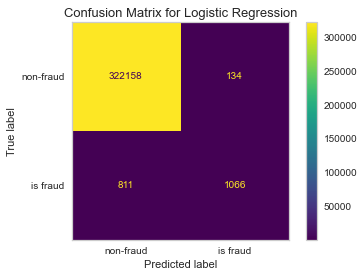

In [238]:
plot_confusion_matrix(lr, 'Logistic Regression', X_test_sc, y_test)

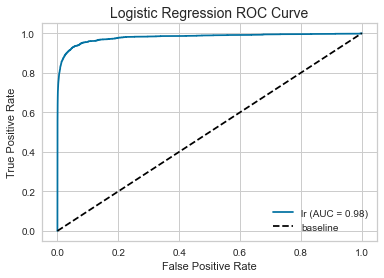

In [239]:
# plot roc curve
plot_roc_curve(lr, X_test_sc, y_test, name = 'lr')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Logistic Regression ROC Curve', fontsize=14)
plt.legend();

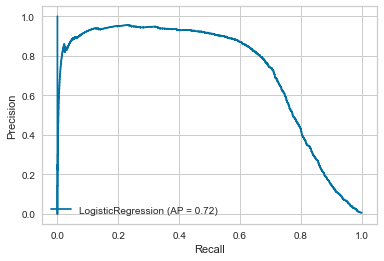

In [240]:
plot_precision_recall_curve(lr, X_test_sc, y_test);

__PRECISION-RECALL CURVES__

It is used for evaluating the performance of binary classificaiton where there is super imbalanced classes.

In [241]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
1,XGBClassifier,0.999974,0.999352,0.981514,0.905168,0.888984,0.941796,0.999529
2,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854


### Gaussian Naive Bayes

In [242]:
%%time

gnb = GaussianNB()

# Fit our model.
gnb.fit(X_train, y_train)

CPU times: total: 8.17 s
Wall time: 8.81 s


GaussianNB(priors=None, var_smoothing=1e-09)

In [243]:
# print the summarize report and store the values
run_score(gnb, 'Gaussian Naive Bayes')

====== Gaussian Naive Bayes's Metrics ======
Train Score: 0.9787456324176921
Test Score: 0.9783970706637587
Precision Score: 0.17540526849037488
Recall Score: 0.7378795950985615
Average Precision: 0.13094569535652323
f1-Score: 0.28343395068044613
roc_auc Score: 0.9474239768711479

== confusion matrix ==
True Negatives: 315781
False Positives: 6511
False Negatives: 492
True Positives: 1385


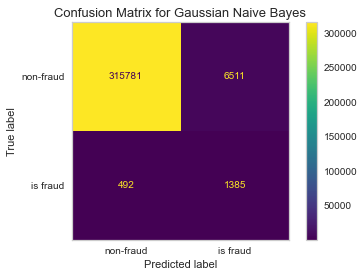

In [244]:
plot_confusion_matrix(gnb, 'Gaussian Naive Bayes', X_test, y_test)

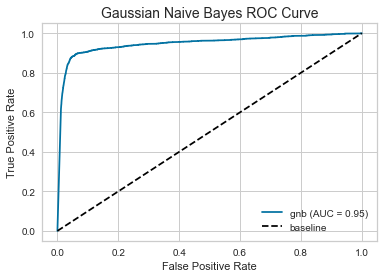

In [245]:
# plot roc curve
plot_roc_curve(gnb, X_test, y_test, name = 'gnb')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Gaussian Naive Bayes ROC Curve', fontsize=14)
plt.legend();

In [246]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
1,XGBClassifier,0.999974,0.999352,0.981514,0.905168,0.888984,0.941796,0.999529
2,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
3,Gaussian Naive Bayes,0.978746,0.978397,0.175405,0.737880,0.130946,0.283434,0.947424


### Random Forest Classifier

In [247]:
%%time

rf = RandomForestClassifier(random_state = 42)

# Fit our model.
rf.fit(X_train, y_train)

CPU times: total: 6min
Wall time: 6min


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [248]:
# print the summarize report and store the values
run_score(rf, 'Random Forest Classifier')

====== Random Forest Classifier's Metrics ======
Train Score: 1.0
Test Score: 0.9987814997732665
Precision Score: 0.9793014230271668
Recall Score: 0.8066062866275973
Average Precision: 0.7910304706013794
f1-Score: 0.8846041484078293
roc_auc Score: 0.9944631583938539

== confusion matrix ==
True Negatives: 322260
False Positives: 32
False Negatives: 363
True Positives: 1514


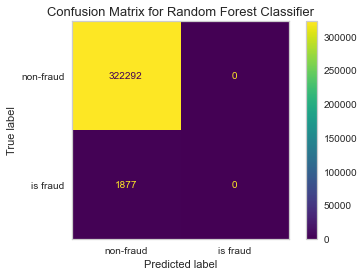

In [249]:
plot_confusion_matrix(rf, 'Random Forest Classifier', X_test_sc, y_test)

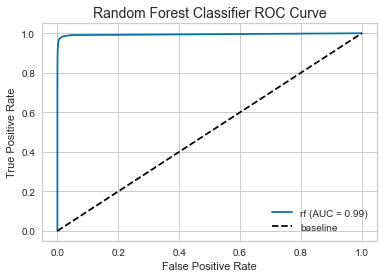

In [250]:
# plot roc curve
plot_roc_curve(rf, X_test, y_test, name = 'rf')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Random Forest Classifier ROC Curve', fontsize=14)
plt.legend();

In [251]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
1,XGBClassifier,0.999974,0.999352,0.981514,0.905168,0.888984,0.941796,0.999529
2,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
3,Gaussian Naive Bayes,0.978746,0.978397,0.175405,0.737880,0.130946,0.283434,0.947424
4,Random Forest Classifier,1.000000,0.998781,0.979301,0.806606,0.791030,0.884604,0.994463


### XGBoost

In [252]:
%%time

# Instantiate the model
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, seed=42)

# Fit the model
xgb.fit(X_train, y_train)

CPU times: total: 32min 16s
Wall time: 2min 9s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [253]:
# print the summarize report and store the values
run_score(xgb, 'XGBClassifier')

====== XGBClassifier's Metrics ======
Train Score: 0.9999742932177282
Test Score: 0.9993521897528758
Precision Score: 0.9815135759676488
Recall Score: 0.905167820990943
Average Precision: 0.8889836011363702
f1-Score: 0.9417960088691796
roc_auc Score: 0.9995287573677879

== confusion matrix ==
True Negatives: 322260
False Positives: 32
False Negatives: 178
True Positives: 1699


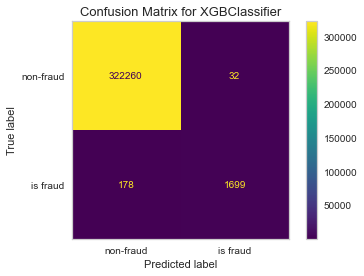

In [254]:
plot_confusion_matrix(xgb, 'XGBClassifier', X_test, y_test)

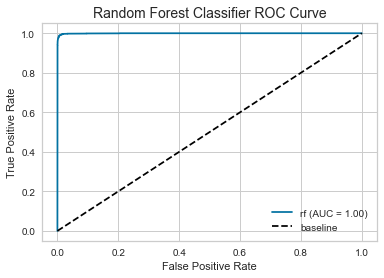

In [255]:
# plot roc curve
plot_roc_curve(xgb, X_test, y_test, name = 'rf')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Random Forest Classifier ROC Curve', fontsize=14)
plt.legend();

In [256]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
1,XGBClassifier,0.999974,0.999352,0.981514,0.905168,0.888984,0.941796,0.999529
2,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
3,Gaussian Naive Bayes,0.978746,0.978397,0.175405,0.737880,0.130946,0.283434,0.947424
4,Random Forest Classifier,1.000000,0.998781,0.979301,0.806606,0.791030,0.884604,0.994463
5,XGBClassifier,0.999974,0.999352,0.981514,0.905168,0.888984,0.941796,0.999529


### LightGBM

In [257]:
%%time

# Instantiate the model
lgb = LGBMClassifier(seed=42)

# Fit the model
lgb.fit(X_train, y_train)

CPU times: total: 1min 6s
Wall time: 6.61 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [258]:
# print the summarize report and store the values
run_score(lgb, 'LGBMClassifier')

====== LGBMClassifier's Metrics ======
Train Score: 0.996422644179059
Test Score: 0.9957614700973875
Precision Score: 0.6017806556050183
Recall Score: 0.7922216302610549
Average Precision: 0.4779467282162046
f1-Score: 0.6839926402943883
roc_auc Score: 0.9202203479035853

== confusion matrix ==
True Negatives: 321308
False Positives: 984
False Negatives: 390
True Positives: 1487


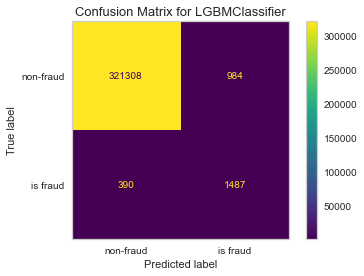

In [259]:
plot_confusion_matrix(lgb, 'LGBMClassifier', X_test, y_test)

In [260]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
1,XGBClassifier,0.999974,0.999352,0.981514,0.905168,0.888984,0.941796,0.999529
2,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
3,Gaussian Naive Bayes,0.978746,0.978397,0.175405,0.737880,0.130946,0.283434,0.947424
4,Random Forest Classifier,1.000000,0.998781,0.979301,0.806606,0.791030,0.884604,0.994463
5,XGBClassifier,0.999974,0.999352,0.981514,0.905168,0.888984,0.941796,0.999529
6,LGBMClassifier,0.996423,0.995761,0.601781,0.792222,0.477947,0.683993,0.920220


### CatBoost

In [261]:
%%time
cat = CatBoostClassifier(random_seed=42)
cat.fit(X_train, y_train)

Learning rate set to 0.19443
0:	learn: 0.2216457	total: 89.5ms	remaining: 1m 29s
1:	learn: 0.0752908	total: 168ms	remaining: 1m 23s
2:	learn: 0.0331190	total: 238ms	remaining: 1m 19s
3:	learn: 0.0209682	total: 314ms	remaining: 1m 18s
4:	learn: 0.0139446	total: 391ms	remaining: 1m 17s
5:	learn: 0.0116771	total: 474ms	remaining: 1m 18s
6:	learn: 0.0098368	total: 557ms	remaining: 1m 19s
7:	learn: 0.0084316	total: 636ms	remaining: 1m 18s
8:	learn: 0.0075643	total: 711ms	remaining: 1m 18s
9:	learn: 0.0071791	total: 780ms	remaining: 1m 17s
10:	learn: 0.0067969	total: 848ms	remaining: 1m 16s
11:	learn: 0.0062845	total: 923ms	remaining: 1m 16s
12:	learn: 0.0061018	total: 992ms	remaining: 1m 15s
13:	learn: 0.0058209	total: 1.07s	remaining: 1m 15s
14:	learn: 0.0056672	total: 1.14s	remaining: 1m 14s
15:	learn: 0.0052145	total: 1.21s	remaining: 1m 14s
16:	learn: 0.0050986	total: 1.28s	remaining: 1m 13s
17:	learn: 0.0049594	total: 1.35s	remaining: 1m 13s
18:	learn: 0.0048796	total: 1.43s	remaining:

159:	learn: 0.0016064	total: 11.8s	remaining: 1m 2s
160:	learn: 0.0016023	total: 11.9s	remaining: 1m 1s
161:	learn: 0.0016010	total: 11.9s	remaining: 1m 1s
162:	learn: 0.0015938	total: 12s	remaining: 1m 1s
163:	learn: 0.0015915	total: 12.1s	remaining: 1m 1s
164:	learn: 0.0015840	total: 12.2s	remaining: 1m 1s
165:	learn: 0.0015791	total: 12.2s	remaining: 1m 1s
166:	learn: 0.0015730	total: 12.3s	remaining: 1m 1s
167:	learn: 0.0015672	total: 12.4s	remaining: 1m 1s
168:	learn: 0.0015590	total: 12.5s	remaining: 1m 1s
169:	learn: 0.0015568	total: 12.5s	remaining: 1m 1s
170:	learn: 0.0015506	total: 12.6s	remaining: 1m 1s
171:	learn: 0.0015423	total: 12.7s	remaining: 1m
172:	learn: 0.0015387	total: 12.7s	remaining: 1m
173:	learn: 0.0015375	total: 12.8s	remaining: 1m
174:	learn: 0.0015221	total: 12.9s	remaining: 1m
175:	learn: 0.0015127	total: 13s	remaining: 1m
176:	learn: 0.0015091	total: 13.1s	remaining: 1m
177:	learn: 0.0015051	total: 13.1s	remaining: 1m
178:	learn: 0.0015008	total: 13.2s	re

319:	learn: 0.0009611	total: 23.4s	remaining: 49.8s
320:	learn: 0.0009574	total: 23.5s	remaining: 49.7s
321:	learn: 0.0009524	total: 23.6s	remaining: 49.6s
322:	learn: 0.0009488	total: 23.6s	remaining: 49.6s
323:	learn: 0.0009480	total: 23.7s	remaining: 49.5s
324:	learn: 0.0009464	total: 23.8s	remaining: 49.4s
325:	learn: 0.0009442	total: 23.9s	remaining: 49.3s
326:	learn: 0.0009430	total: 23.9s	remaining: 49.3s
327:	learn: 0.0009364	total: 24s	remaining: 49.2s
328:	learn: 0.0009325	total: 24.1s	remaining: 49.1s
329:	learn: 0.0009305	total: 24.2s	remaining: 49.1s
330:	learn: 0.0009263	total: 24.2s	remaining: 49s
331:	learn: 0.0009210	total: 24.3s	remaining: 48.9s
332:	learn: 0.0009200	total: 24.4s	remaining: 48.8s
333:	learn: 0.0009118	total: 24.5s	remaining: 48.8s
334:	learn: 0.0009099	total: 24.5s	remaining: 48.7s
335:	learn: 0.0009072	total: 24.6s	remaining: 48.6s
336:	learn: 0.0009058	total: 24.7s	remaining: 48.5s
337:	learn: 0.0009034	total: 24.7s	remaining: 48.5s
338:	learn: 0.00

478:	learn: 0.0006321	total: 35s	remaining: 38.1s
479:	learn: 0.0006302	total: 35.1s	remaining: 38s
480:	learn: 0.0006285	total: 35.1s	remaining: 37.9s
481:	learn: 0.0006270	total: 35.2s	remaining: 37.8s
482:	learn: 0.0006266	total: 35.3s	remaining: 37.8s
483:	learn: 0.0006250	total: 35.4s	remaining: 37.7s
484:	learn: 0.0006228	total: 35.4s	remaining: 37.6s
485:	learn: 0.0006182	total: 35.5s	remaining: 37.5s
486:	learn: 0.0006158	total: 35.6s	remaining: 37.5s
487:	learn: 0.0006129	total: 35.6s	remaining: 37.4s
488:	learn: 0.0006117	total: 35.7s	remaining: 37.3s
489:	learn: 0.0006095	total: 35.8s	remaining: 37.2s
490:	learn: 0.0006076	total: 35.9s	remaining: 37.2s
491:	learn: 0.0006023	total: 35.9s	remaining: 37.1s
492:	learn: 0.0006001	total: 36s	remaining: 37s
493:	learn: 0.0005963	total: 36.1s	remaining: 37s
494:	learn: 0.0005956	total: 36.2s	remaining: 36.9s
495:	learn: 0.0005947	total: 36.2s	remaining: 36.8s
496:	learn: 0.0005938	total: 36.3s	remaining: 36.8s
497:	learn: 0.0005935	

638:	learn: 0.0004365	total: 46.7s	remaining: 26.4s
639:	learn: 0.0004357	total: 46.7s	remaining: 26.3s
640:	learn: 0.0004351	total: 46.8s	remaining: 26.2s
641:	learn: 0.0004345	total: 46.9s	remaining: 26.1s
642:	learn: 0.0004331	total: 47s	remaining: 26.1s
643:	learn: 0.0004317	total: 47s	remaining: 26s
644:	learn: 0.0004312	total: 47.1s	remaining: 25.9s
645:	learn: 0.0004310	total: 47.2s	remaining: 25.9s
646:	learn: 0.0004271	total: 47.3s	remaining: 25.8s
647:	learn: 0.0004246	total: 47.4s	remaining: 25.7s
648:	learn: 0.0004243	total: 47.5s	remaining: 25.7s
649:	learn: 0.0004237	total: 47.5s	remaining: 25.6s
650:	learn: 0.0004232	total: 47.6s	remaining: 25.5s
651:	learn: 0.0004211	total: 47.7s	remaining: 25.4s
652:	learn: 0.0004194	total: 47.7s	remaining: 25.4s
653:	learn: 0.0004178	total: 47.8s	remaining: 25.3s
654:	learn: 0.0004166	total: 47.9s	remaining: 25.2s
655:	learn: 0.0004165	total: 48s	remaining: 25.2s
656:	learn: 0.0004160	total: 48s	remaining: 25.1s
657:	learn: 0.0004146	

798:	learn: 0.0003062	total: 58.5s	remaining: 14.7s
799:	learn: 0.0003053	total: 58.5s	remaining: 14.6s
800:	learn: 0.0003044	total: 58.6s	remaining: 14.6s
801:	learn: 0.0003034	total: 58.7s	remaining: 14.5s
802:	learn: 0.0003025	total: 58.8s	remaining: 14.4s
803:	learn: 0.0003022	total: 58.9s	remaining: 14.3s
804:	learn: 0.0003020	total: 58.9s	remaining: 14.3s
805:	learn: 0.0003015	total: 59s	remaining: 14.2s
806:	learn: 0.0003007	total: 59.1s	remaining: 14.1s
807:	learn: 0.0002990	total: 59.2s	remaining: 14.1s
808:	learn: 0.0002989	total: 59.2s	remaining: 14s
809:	learn: 0.0002977	total: 59.3s	remaining: 13.9s
810:	learn: 0.0002974	total: 59.4s	remaining: 13.8s
811:	learn: 0.0002969	total: 59.5s	remaining: 13.8s
812:	learn: 0.0002958	total: 59.5s	remaining: 13.7s
813:	learn: 0.0002954	total: 59.6s	remaining: 13.6s
814:	learn: 0.0002946	total: 59.7s	remaining: 13.5s
815:	learn: 0.0002944	total: 59.8s	remaining: 13.5s
816:	learn: 0.0002942	total: 59.8s	remaining: 13.4s
817:	learn: 0.00

958:	learn: 0.0002246	total: 1m 10s	remaining: 3.01s
959:	learn: 0.0002246	total: 1m 10s	remaining: 2.94s
960:	learn: 0.0002246	total: 1m 10s	remaining: 2.86s
961:	learn: 0.0002245	total: 1m 10s	remaining: 2.79s
962:	learn: 0.0002244	total: 1m 10s	remaining: 2.71s
963:	learn: 0.0002240	total: 1m 10s	remaining: 2.64s
964:	learn: 0.0002237	total: 1m 10s	remaining: 2.57s
965:	learn: 0.0002236	total: 1m 10s	remaining: 2.49s
966:	learn: 0.0002228	total: 1m 10s	remaining: 2.42s
967:	learn: 0.0002227	total: 1m 11s	remaining: 2.35s
968:	learn: 0.0002226	total: 1m 11s	remaining: 2.27s
969:	learn: 0.0002215	total: 1m 11s	remaining: 2.2s
970:	learn: 0.0002208	total: 1m 11s	remaining: 2.13s
971:	learn: 0.0002206	total: 1m 11s	remaining: 2.05s
972:	learn: 0.0002203	total: 1m 11s	remaining: 1.98s
973:	learn: 0.0002201	total: 1m 11s	remaining: 1.91s
974:	learn: 0.0002199	total: 1m 11s	remaining: 1.83s
975:	learn: 0.0002196	total: 1m 11s	remaining: 1.76s
976:	learn: 0.0002187	total: 1m 11s	remaining: 

In [262]:
# print the summarize report and store the values
run_score(cat, 'CatBoostClassifier')

====== CatBoostClassifier's Metrics ======
Train Score: 0.9999897172870913
Test Score: 0.999441649263193
Precision Score: 0.9879171461449943
Recall Score: 0.9147575919019713
Average Precision: 0.9041982793183574
f1-Score: 0.9499308437067774
roc_auc Score: 0.9996219092603251

== confusion matrix ==
True Negatives: 322271
False Positives: 21
False Negatives: 160
True Positives: 1717


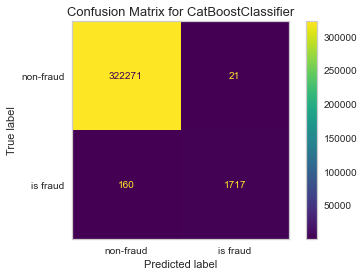

In [263]:
plot_confusion_matrix(cat, 'CatBoostClassifier', X_test, y_test)

In [264]:
# Updated evaluation list
model_eval_df = pd.DataFrame(evaluation_list)
model_eval_df

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
1,XGBClassifier,0.999974,0.999352,0.981514,0.905168,0.888984,0.941796,0.999529
2,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
3,Gaussian Naive Bayes,0.978746,0.978397,0.175405,0.737880,0.130946,0.283434,0.947424
4,Random Forest Classifier,1.000000,0.998781,0.979301,0.806606,0.791030,0.884604,0.994463
5,XGBClassifier,0.999974,0.999352,0.981514,0.905168,0.888984,0.941796,0.999529
6,LGBMClassifier,0.996423,0.995761,0.601781,0.792222,0.477947,0.683993,0.920220
7,CatBoostClassifier,0.999990,0.999442,0.987917,0.914758,0.904198,0.949931,0.999622


In [265]:
# check the trained models and sort by F1 Score
model_eval_df.sort_values(['f1_score','recall'], ascending=False)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
7,CatBoostClassifier,0.999990,0.999442,0.987917,0.914758,0.904198,0.949931,0.999622
1,XGBClassifier,0.999974,0.999352,0.981514,0.905168,0.888984,0.941796,0.999529
5,XGBClassifier,0.999974,0.999352,0.981514,0.905168,0.888984,0.941796,0.999529
4,Random Forest Classifier,1.000000,0.998781,0.979301,0.806606,0.791030,0.884604,0.994463
0,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
2,Logistic Regression,0.997259,0.997085,0.888333,0.567928,0.507011,0.692883,0.979854
6,LGBMClassifier,0.996423,0.995761,0.601781,0.792222,0.477947,0.683993,0.920220
3,Gaussian Naive Bayes,0.978746,0.978397,0.175405,0.737880,0.130946,0.283434,0.947424


### AutoML: PyCaret

In [209]:
# merged the X_encoded and y for AutoML
train_final_merged = pd.concat([X_encoded, y], axis=1)
train_final_merged.head(2)

,amt,is_male,age,distance,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,diff_minutes_pre_trans,...,cluster_37,cluster_38,cluster_39,cluster_40,cluster_41,cluster_42,cluster_43,trans_week_53,amt_group_very_low,is_fraud
0,7.27,0,33,127.629296,0.00,7.27,0.00,0.000000,7.270,0.0,...,0,0,0,0,0,0,1,0,0,0
1,52.94,0,33,110.202992,7.27,60.21,45.67,6.281981,30.105,1197.7,...,0,0,0,0,0,0,1,0,0,0


In [210]:
train_final_merged.shape

(1296675, 295)

In [211]:
# check the merged df info
train_final_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Columns: 295 entries, amt to is_fraud
dtypes: float64(45), int32(249), int64(1)
memory usage: 1.7 GB


In [212]:
# Set up an experiment for PyCaret
clf = setup(
    data = train_final_merged,
    target = 'is_fraud',
    train_size = 0.75,
    data_split_shuffle = True,
    data_split_stratify = True,
    html=False,
    silent=True,
    preprocess = False,
    verbose=False,
    session_id = 42,
    fix_imbalance = False, 
    use_gpu=True)

In [213]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [214]:
%%time

best = compare_models(include = ['catboost', 'xgboost'], sort = 'F1') 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9993,0.9991,0.8947,0.9738,0.9325,0.9321,0.933,16.315


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9994,0.9996,0.9126,0.9791,0.9446,0.9443,0.9449,12.435
catboost,CatBoost Classifier,0.9993,0.9991,0.8947,0.9738,0.9325,0.9321,0.9330,16.315


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9994,0.9996,0.9126,0.9791,0.9446,0.9443,0.9449,12.435
catboost,CatBoost Classifier,0.9993,0.9991,0.8947,0.9738,0.9325,0.9321,0.9330,16.315


CPU times: total: 12min 16s
Wall time: 5min 2s
Parser   : 219 ms


In [215]:
print(best)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=1, verbosity=0)


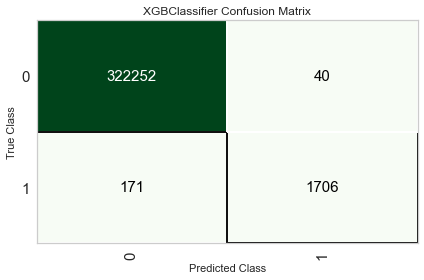

In [216]:
plot_model(best, plot = 'confusion_matrix')

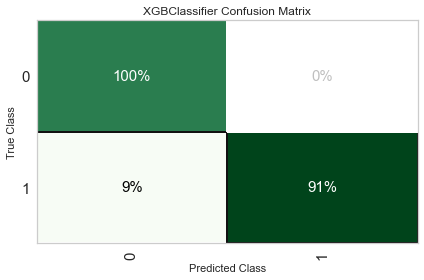

In [217]:
plot_model(best, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

In [218]:
%%time

# Hyperparameters Tuning
tuned_best = tune_model(best, n_iter = 20, 
                        choose_better=True, 
                        optimize='F1', 
                        return_tuner=True)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 46.6min finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9994,0.9994,0.9449,0.9586,0.9517,0.9514,0.9514
1,0.9994,0.9997,0.9414,0.9464,0.9439,0.9436,0.9436
2,0.9993,0.9995,0.9165,0.9609,0.9382,0.9378,0.9381
3,0.9994,0.9996,0.9414,0.9567,0.9490,0.9487,0.9487
4,0.9995,0.9997,0.9414,0.9707,0.9558,0.9556,0.9557
5,0.9995,0.9999,0.9467,0.9673,0.9569,0.9567,0.9567
6,0.9995,0.9999,0.9502,0.9656,0.9578,0.9576,0.9576
7,0.9995,0.9998,0.9503,0.9588,0.9545,0.9542,0.9543
8,0.9994,0.9998,0.9520,0.9520,0.9520,0.9518,0.9518
9,0.9994,0.9997,0.9432,0.9568,0.9499,0.9496,0.9496


CPU times: total: 2h 16min 15s
Wall time: 53min 13s


In [219]:
print(tuned_best)

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=190, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0.7, reg_lambda=1,
              scale_pos_weight=39.0, subsample=0.9, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=1, verbosity=0), RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('empty_step', 'passthrough'),
                                          

In [220]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x000002A8ADDAB430>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<function roc_auc_score at 0x000002A8ADDA3280>,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x000002A8ADDAB...,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x000002A8ADDAB...,make_scorer(matthews_corrcoef),pred,{},True,True,False


In [221]:
# automl 
best_model = automl(optimize = 'F1')
print(best_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=190, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0.7, reg_lambda=1,
              scale_pos_weight=39.0, subsample=0.9, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=1, verbosity=0)


In [222]:
# save model under PyCaret
save_model(best_model, '../datasets/best_model')

# save config
save_config('../datasets/my_config')

Transformation Pipeline and Model Successfully Saved


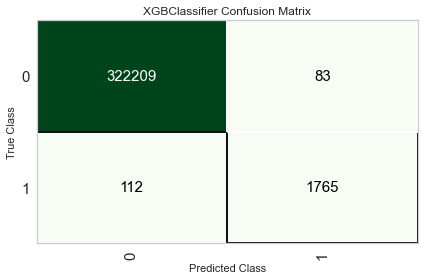

In [223]:
plot_model(best_model, plot = 'confusion_matrix')

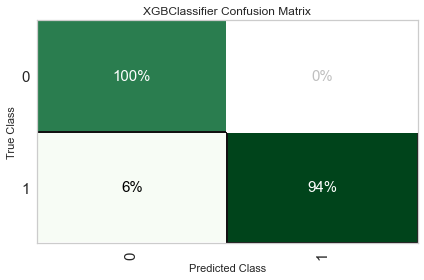

In [224]:
plot_model(best_model, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

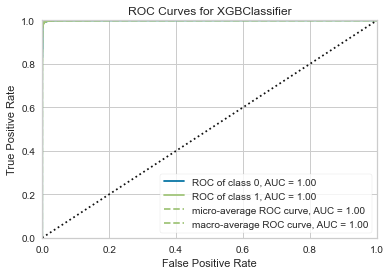

In [225]:
plot_model(best_model)

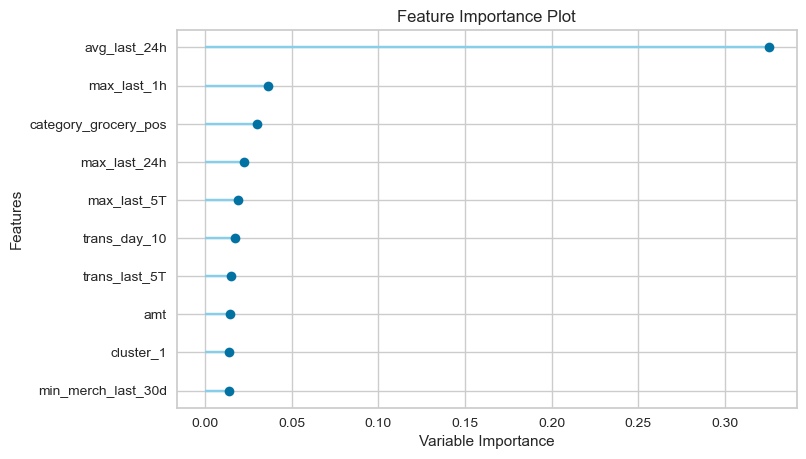

In [226]:
plot_model(best_model, plot = 'feature')

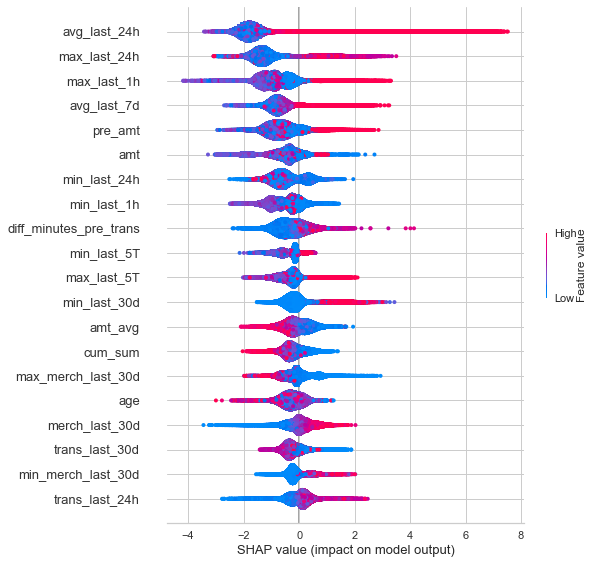

In [227]:
interpret_model(best_model)

In [49]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

ValueError: Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.

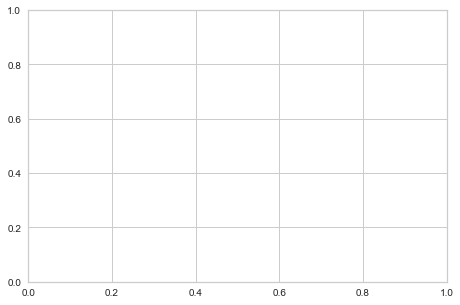

In [57]:
interpret_model(best_model, plot = 'correlation')

In [ ]:
xxx

### Neural Network

In [77]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense # equal to fully connected
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import EarlyStopping


In [110]:
# Instantiate model
model = Sequential()

In [111]:
# One by one, add Dense layers to our model.
# The hidden layers will use the ReLU activation
# Output layer will have softmax
model.add(Dense(256, activation="relu", input_shape= (X_train_sc.shape[1],))) 
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [112]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               73984     
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 90,497
Trainable params: 90,497
Non-trainable params: 0
_________________________________________________________________


In [113]:
metrics = ['accuracy',
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp")
#     keras.metrics.Precision(name="precision"),
#     keras.metrics.Recall(name="recall"),
]

# We need to compile our model in Keras.
# Need to tell it three things:
# Optimizer (for us, usually Adam)
# Loss (which?)
# Metrics (Definitely need accuracy, but could do more)

#opt = SGD(learning_rate=0.01)
#opt = Adam(learning_rate=0.001) #10 to 20 epoch is max, if want then can increase the learning_rate

model.compile(
    optimizer= 'adam', #Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=metrics
)

# # Model Fit
# early_stop = EarlyStopping(monitor='val_loss', 
#                            min_delta=0, 
#                            patience=10, 
#                            mode='auto')

In [114]:
# Fit!
# Need to specify batch_size and epochs
# Can validate with validation_split
hist = model.fit(
    X_train_sc, y_train,
    batch_size=50,
    epochs=100,
    validation_data=(X_test_sc, y_test)
#     callbacks=[early_stop] # Add your callbacks here!
)

Epoch 1/100
19451/19451 [==============================] - 24s 1ms/step - loss: 0.0078 - accuracy: 0.9979 - fn: 1596.0000 - fp: 494.0000 - tn: 966383.0000 - tp: 4033.0000 - val_loss: 0.0062 - val_accuracy: 0.9983 - val_fn: 497.0000 - val_fp: 59.0000 - val_tn: 322233.0000 - val_tp: 1380.0000
Epoch 2/100
19451/19451 [==============================] - 22s 1ms/step - loss: 0.0045 - accuracy: 0.9987 - fn: 952.0000 - fp: 312.0000 - tn: 966565.0000 - tp: 4677.0000 - val_loss: 0.0051 - val_accuracy: 0.9986 - val_fn: 392.0000 - val_fp: 49.0000 - val_tn: 322243.0000 - val_tp: 1485.0000
Epoch 3/100
19451/19451 [==============================] - 22s 1ms/step - loss: 0.0036 - accuracy: 0.9991 - fn: 665.0000 - fp: 244.0000 - tn: 966633.0000 - tp: 4964.0000 - val_loss: 0.0065 - val_accuracy: 0.9988 - val_fn: 308.0000 - val_fp: 96.0000 - val_tn: 322196.0000 - val_tp: 1569.0000
Epoch 4/100
19451/19451 [==============================] - 23s 1ms/step - loss: 0.0028 - accuracy: 0.9992 - fn: 512.0000 - fp:

Epoch 29/100
19451/19451 [==============================] - 23s 1ms/step - loss: 3.7576e-04 - accuracy: 0.9999 - fn: 38.0000 - fp: 32.0000 - tn: 966845.0000 - tp: 5591.0000 - val_loss: 0.0358 - val_accuracy: 0.9988 - val_fn: 227.0000 - val_fp: 160.0000 - val_tn: 322132.0000 - val_tp: 1650.0000
Epoch 30/100
19451/19451 [==============================] - 23s 1ms/step - loss: 5.7481e-04 - accuracy: 0.9999 - fn: 35.0000 - fp: 29.0000 - tn: 966848.0000 - tp: 5594.0000 - val_loss: 0.0411 - val_accuracy: 0.9989 - val_fn: 249.0000 - val_fp: 105.0000 - val_tn: 322187.0000 - val_tp: 1628.0000
Epoch 31/100
19451/19451 [==============================] - 23s 1ms/step - loss: 0.0032 - accuracy: 0.9999 - fn: 39.0000 - fp: 36.0000 - tn: 966841.0000 - tp: 5590.0000 - val_loss: 0.0390 - val_accuracy: 0.9988 - val_fn: 225.0000 - val_fp: 152.0000 - val_tn: 322140.0000 - val_tp: 1652.0000
Epoch 32/100
19451/19451 [==============================] - 23s 1ms/step - loss: 8.4531e-04 - accuracy: 0.9999 - fn: 38

Epoch 57/100
19451/19451 [==============================] - 23s 1ms/step - loss: 3.9914e-04 - accuracy: 1.0000 - fn: 17.0000 - fp: 19.0000 - tn: 966858.0000 - tp: 5612.0000 - val_loss: 0.0788 - val_accuracy: 0.9989 - val_fn: 279.0000 - val_fp: 85.0000 - val_tn: 322207.0000 - val_tp: 1598.0000
Epoch 58/100
19451/19451 [==============================] - 23s 1ms/step - loss: 0.0014 - accuracy: 1.0000 - fn: 21.0000 - fp: 22.0000 - tn: 966855.0000 - tp: 5608.0000 - val_loss: 0.0710 - val_accuracy: 0.9988 - val_fn: 274.0000 - val_fp: 104.0000 - val_tn: 322188.0000 - val_tp: 1603.0000
Epoch 59/100
19451/19451 [==============================] - 22s 1ms/step - loss: 9.8108e-04 - accuracy: 0.9999 - fn: 30.0000 - fp: 31.0000 - tn: 966846.0000 - tp: 5599.0000 - val_loss: 0.0706 - val_accuracy: 0.9989 - val_fn: 210.0000 - val_fp: 147.0000 - val_tn: 322145.0000 - val_tp: 1667.0000
Epoch 60/100
19451/19451 [==============================] - 23s 1ms/step - loss: 8.9967e-04 - accuracy: 0.9999 - fn: 29.

Epoch 85/100
19451/19451 [==============================] - 23s 1ms/step - loss: 0.0030 - accuracy: 1.0000 - fn: 21.0000 - fp: 20.0000 - tn: 966857.0000 - tp: 5608.0000 - val_loss: 0.0987 - val_accuracy: 0.9989 - val_fn: 258.0000 - val_fp: 107.0000 - val_tn: 322185.0000 - val_tp: 1619.0000
Epoch 86/100
19451/19451 [==============================] - 24s 1ms/step - loss: 9.7144e-04 - accuracy: 1.0000 - fn: 22.0000 - fp: 23.0000 - tn: 966854.0000 - tp: 5607.0000 - val_loss: 0.0824 - val_accuracy: 0.9988 - val_fn: 225.0000 - val_fp: 179.0000 - val_tn: 322113.0000 - val_tp: 1652.0000
Epoch 87/100
19451/19451 [==============================] - 24s 1ms/step - loss: 5.5722e-04 - accuracy: 1.0000 - fn: 23.0000 - fp: 21.0000 - tn: 966856.0000 - tp: 5606.0000 - val_loss: 0.1016 - val_accuracy: 0.9989 - val_fn: 232.0000 - val_fp: 117.0000 - val_tn: 322175.0000 - val_tp: 1645.0000
Epoch 88/100
19451/19451 [==============================] - 23s 1ms/step - loss: 6.2002e-04 - accuracy: 0.9999 - fn: 24

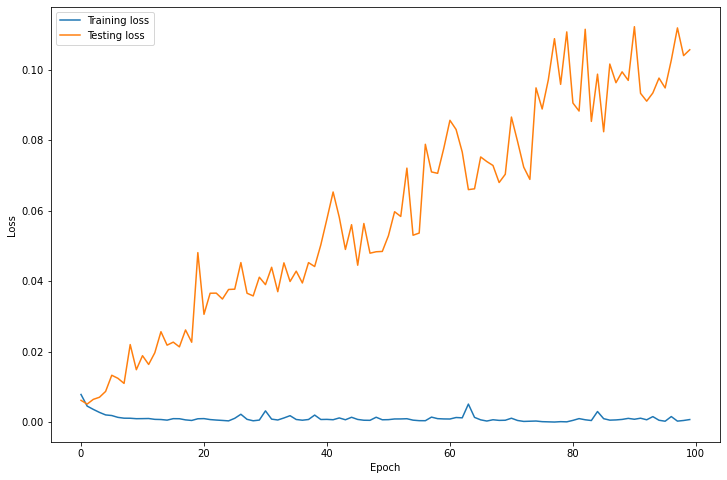

In [116]:
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [ ]:
# DNN with SMOTE
# https://towardsdatascience.com/credit-card-fraud-detection-9bc8db79b956